# Classification Model
* File Name: Reference_implementation of MNIST with MLFlow
* Date of creation(dd-mm-yyyy) : 09-12-2022
* Author Name/Dept : AIShield
* Organization : BGSW
* Description : Source Code of reference implementation of AIShield API
* Copyright : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Metadata
* Dataset: MNIST
* Size of training set:54,000
* Size of testing set : 10,000
* Size of validation set : 6000
* Number of class : 10
* Original Model: CNN

### Outcomes
* Accuracy of model: 0.99


In [1]:
"""
Description: command to install all the packages, remove comment to install all the library
"""
# ! pip install -r requirements.txt

'\nDescription: command to install all the packages, remove comment to install all the library\n'

# 1.0 Importing libraries

In [2]:
"""
Description: Import libraries
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import zipfile 
import pandas as pd
import cv2
import os
import random
import requests
import json
import time
from tqdm import tqdm
import shutil
from humanfriendly import format_timespan
import mlflow

# 2.0 Data Loading and Preprocessing

In [3]:
'''
Description : Loading mnist dataset
'''
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

In [4]:
'''
Description : Splitting data for validation
'''
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

In [5]:
'''
Description : Check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


In [6]:
def plot(x, y=None, row: int = 2):
    """
    to visualize random sample
    """
    rows = row
    random_indices = random.sample(range(x.shape[0]), rows * rows)
    sample_images = x[random_indices, :]
    if y is not None:
        sample_labels = y[random_indices]

    fig, axs = plt.subplots(nrows=rows, ncols=rows, figsize=(12, 9), sharex=True, sharey=True)
    for i in range(rows * rows):
        subplot_row = i // rows
        subplot_col = i % rows
        axs[subplot_row, subplot_col].imshow(sample_images[i, :])
        if y is not None:
            axs[subplot_row, subplot_col].set_title("Class. %d" % sample_labels[i])
    plt.tight_layout()
    plt.show()

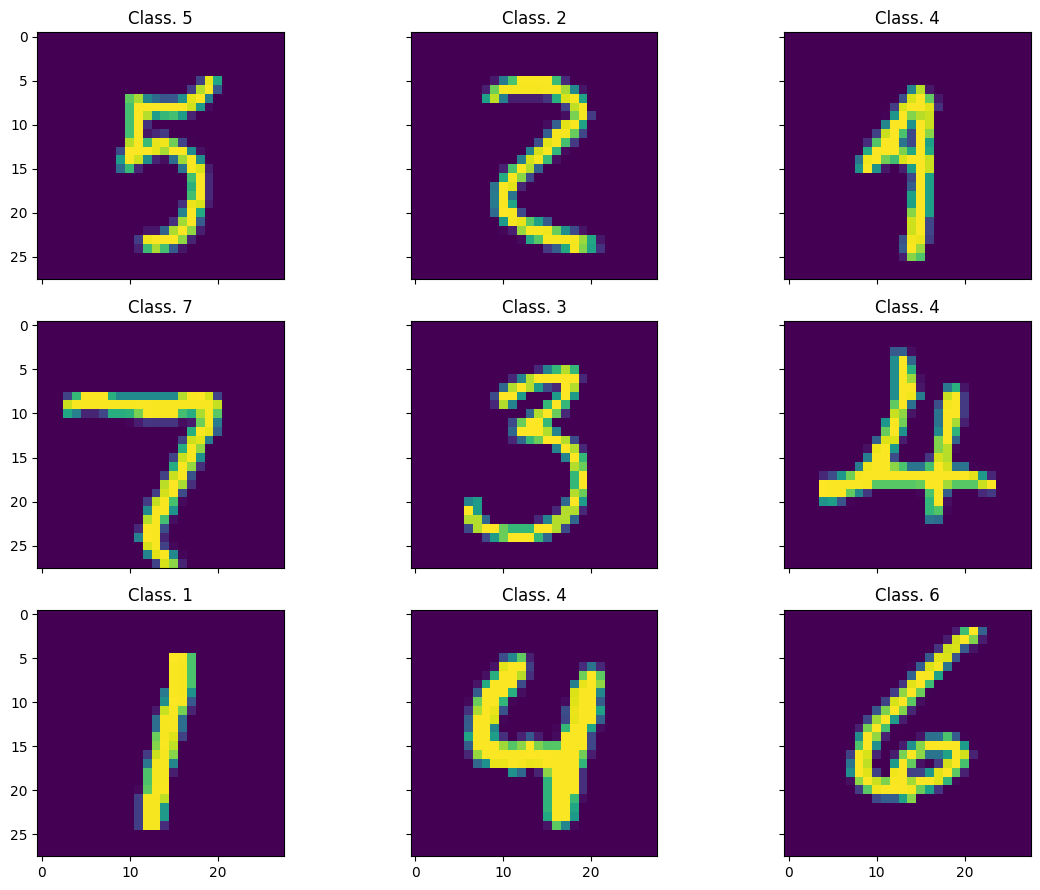

In [7]:
"""
Description: visualize data
"""
plot(X_train, y_train, row=3)

In [8]:
'''
Description : Set num_classes and input shape 
'''
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

In [9]:
"""
Description: Normalizing and reshaping the data
"""
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

In [10]:
"""
Description : Convert label to one hot encoder
"""
y_train=tf.keras.utils.to_categorical(y_train,num_classes)
y_test=tf.keras.utils.to_categorical(y_test,num_classes)

# 3.0 Model Development and Training

In [11]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [12]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
                

In [13]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [14]:
def get_file_path(path):
    """
    To get full file path from directory and child directory
    Args:
        path: Directory path

    Returns: list containing full path of all the file from the given directory

    """
    list_id = []
    for (root, dirs, files) in os.walk(path, topdown=True):
        if len(dirs) == 0:
            for file in files:
                list_id.append(os.path.join(root, file))
    return list_id

In [66]:
"""
Description : Create data, model and label folder
"""
mnist_data_path = os.path.join(os.getcwd(), "data")
mnist_model_path = os.path.join(os.getcwd(), "model")
mnist_label_path = os.path.join(os.getcwd(), "label")
zip_path = os.path.join(os.getcwd(), "zip")
pyc_model_path = os.path.join(os.getcwd(), "pyc_model")
report_path = os.path.join(os.getcwd(), "reports")
sample_data = os.path.join(report_path, "sample_data")
defense_artifact = os.path.join(report_path, "defense_artifact")
# deleting folder
delete_directory(
    directorys=[mnist_data_path, mnist_model_path, mnist_label_path, zip_path, pyc_model_path, report_path])

# creating folder
make_directory([mnist_data_path, mnist_model_path, mnist_label_path, zip_path, pyc_model_path, report_path, sample_data,
                defense_artifact])

In [16]:
def cnn_model(input_shape=input_shape, num_classes=num_classes):
    """
    Description: Create model architecture
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')  
    ])
    #Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
"""
Description: train model
"""
def train_model(model,X_train, y_train, X_test, y_test,batch_size=16,epochs=5,filename='mnist_model'):
    '''
    Description:Training  model
    Args:
        model:model to train 
        X_train: X_train for training 
        X_test: for validation
        y_train: label for X_train
        y_test: label for X_test
        batch_size: batch size for training model
        epochs: number of epochs to train model 
        filename : name to save extracted model
    '''    
    # Callbacks
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filename+'.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
    ES=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min',restore_best_weights=True)
    
    #train and record time for training
    start_time=time.time()
    history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1, callbacks=[ES,checkpoint],validation_data=(X_test,y_test))#tensorboard_callback,,validation_split=0.05
    elapsed_time = time.time() - start_time
    
    print("Elapsed time: {}".format(format_timespan(elapsed_time)))
    
    return model,history

In [18]:
def Plot_model_training_parameters(training_history):
    """
    Description : plot model to visualize model training 
    
    Args:
        training_history: history from which model training parameter can be taken for plotting 
    """
    loss=training_history.history['loss']
    accuracy=training_history.history['accuracy']
    val_loss=training_history.history['val_loss']
    val_accuracy=training_history.history['val_accuracy']
    epochs_range=np.arange(1,len(loss)+1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.title("Training loss ")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Loss",fontsize=16,fontweight='bold')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range,accuracy,label="Training Accuracy")
    plt.plot(epochs_range,val_accuracy,label="Validation Accuracy")
    plt.title("Training accuracy")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Accuracy",fontsize=16,fontweight='bold')
    plt.legend()
    plt.show()

In [19]:
"""
Description : Created architecture of the model
"""
model=cnn_model()

In [20]:
"""
Description : Get model summary
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [21]:
"""
Description: integrating mlflow for auto logging 
"""
with mlflow.start_run():
    # Enable auto-logging to MLflow to capture TensorBoard metrics.
    mlflow.tensorflow.autolog()
    run_id=mlflow.active_run().info.run_id
    print("Active run id is : {}".format(run_id))
    model,history=train_model(model,X_train, y_train, X_test, y_test,batch_size=32,epochs=20,filename='mnist_model')
    
    # get trained model path
    artifact_path=mlflow.get_artifact_uri('model')

Active run id is : dbaf0d57d2534b21920bfef41bdaf5cb
Epoch 1/20
1688/1688 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9333
Epoch 1: val_loss improved from inf to 0.05322, saving model to mnist_model.h5
1688/1688 [==============================] - 27s 14ms/step - loss: 0.2155 - accuracy: 0.9333 - val_loss: 0.0532 - val_accuracy: 0.9836
Epoch 2/20
1685/1688 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9771
Epoch 2: val_loss improved from 0.05322 to 0.03037, saving model to mnist_model.h5
1688/1688 [==============================] - 23s 13ms/step - loss: 0.0808 - accuracy: 0.9771 - val_loss: 0.0304 - val_accuracy: 0.9907
Epoch 3/20
1687/1688 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9826
Epoch 3: val_loss improved from 0.03037 to 0.02827, saving model to mnist_model.h5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0602 - accuracy: 0.9826 - val_loss: 0.0283 - val_accuracy: 0.9906
Epoc

2022/12/13 11:37:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\PUM8KOR\.conda\envs\AIShield\lib\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: C:\Users\PUM8KOR\AppData\Local\Temp\tmpb_vtm2qr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\PUM8KOR\AppData\Local\Temp\tmpb_vtm2qr\model\data\model\assets
2022/12/13 11:37:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\PUM8KOR\.conda\envs\AIShield\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


Elapsed time: 4 minutes and 45.54 seconds


In [22]:
"""
Description: Get prediction on validation data
"""
pred=model.predict(X_val)

188/188 [==============================] - 1s 4ms/step


In [23]:
"""
Description: Convert prediction from probability to label
"""
y_pred = np.argmax(pred,axis=-1)
y_pred[:10]

array([1, 9, 3, 4, 6, 5, 0, 8, 5, 1], dtype=int64)

In [24]:
"""
Description: Calculate Accuracy
"""
acc=metrics.accuracy_score(y_true=y_val,y_pred=y_pred)
print("Accuracy is : {}".format(acc))

Accuracy is : 0.9911666666666666


In [25]:
"""
Description: Calculate classification report
"""
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       592
           1       1.00      1.00      1.00       674
           2       0.99      0.99      0.99       596
           3       1.00      0.99      0.99       613
           4       0.99      1.00      0.99       584
           5       0.99      0.99      0.99       542
           6       0.99      0.99      0.99       592
           7       0.99      0.98      0.99       627
           8       0.98      0.99      0.98       585
           9       0.99      0.98      0.99       595

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



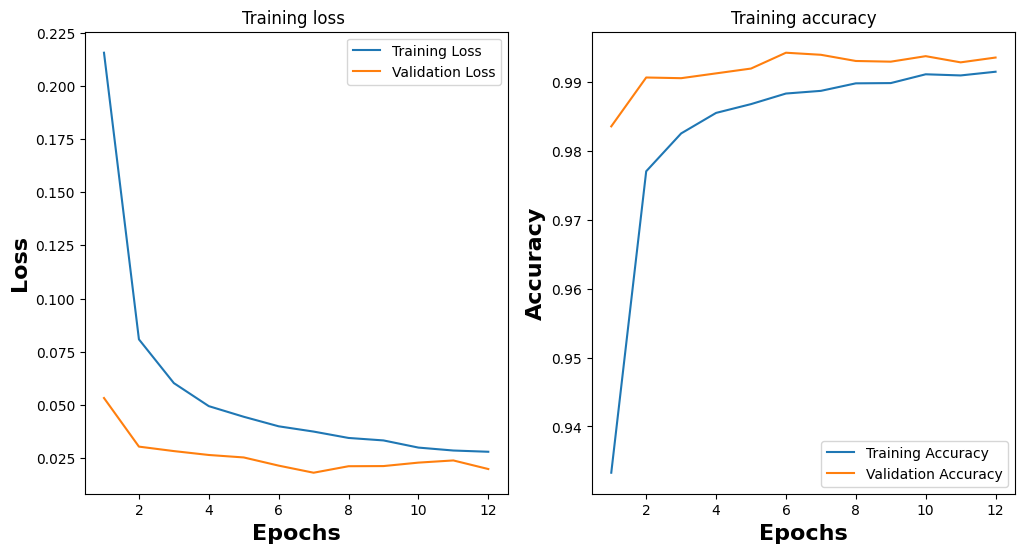

In [26]:
"""
Description: Plot model learning 
"""
Plot_model_training_parameters(history)

# 4.0 Prepare Data , Model and Label

In [27]:
"""
Description: Get logged model path from MLflow
"""
logged_model_path=artifact_path[8:]

In [67]:
"""
Description: Navigate to tensorflow saved format model
"""
model_path=os.path.join(logged_model_path,'data','model')

In [29]:
"""
Description: Load the mlflow flavour model and save again in keras HDF5 format(using working Tensorflow version) 
        to avoid running into issues in version mismatch between mlflow and newest tensorflow versions(>=2.6)
"""
mdl = tf.keras.models.load_model(model_path)
mdl.save(os.path.join(mnist_model_path,'mnist_model.h5'))

In [30]:
def save_data_label(x, y, n, data_path=mnist_data_path, label_path = mnist_label_path):
    """
    x: data
    y: label
    n: number of sample to save
    data_path= path to save data
    label_path = path to save label path
    """
    if len(y.shape)==2:
        y = np.argmax(y, axis=-1)
 
    label=pd.DataFrame()
    img_name = []
    img_label = [] 

    for i in tqdm(range(n)):
        cv2.imwrite(os.path.join(data_path,str(i)+".jpg") ,x[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
        img_name.append(str(i)+".jpg")
        img_label.append(y[i])
    label['image'] = img_name
    label["label"] = img_label

    # write orig_label dataframe
    label.to_csv(os.path.join(label_path,"label.csv"),index=False)

In [31]:
"""
Description: save sample of data and label
"""
save_data_label(x = X_val, y= y_val, n=X_val.shape[0], data_path=mnist_data_path, label_path = mnist_label_path)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 898.90it/s]


In [32]:
"""
Description: Zip data
"""
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=mnist_data_path,zip_format='zip')

In [33]:
"""
Description: Zip label
"""
make_archive(base_name=os.path.join(zip_path,"label"),root_dir=mnist_label_path,zip_format='zip')

In [34]:
"""
Description: save weight of model
"""
model.save_weights(os.path.join(pyc_model_path,"model_weight.h5"))

In [35]:
python_code='''
#import library
import numpy as np
import tensorflow as tf

#define class
class BaseModel():
    """
    class for base model
    """
    def __init__(self,input_shape=(28,28,1),num_classes=10,model_weight_path="model_weight.h5"):
        """
        constructor for class

        Parameters
        ----------
        input_shape : TYPE, optional
            DESCRIPTION. The default is (28,28,1).
        num_classes : TYPE, optional
            DESCRIPTION. The default is 10.
        model_weight_path : string, optional
            DESCRIPTION. the relative path to model weight

        Returns
        -------
        None.

        """
        self.input_shape=input_shape
        self.num_classes=num_classes
        self.model_weight_path=model_weight_path
        

    def cnn_model(self,input_shape,num_classes):
        """
        model architecture

        Parameters
        ----------
        input_shape : string
            DESCRIPTION.input_shape for model e.g (28,28,1)
        num_classes : string
            DESCRIPTION.number of class e.g 10

        Returns
        -------
        model : model
            DESCRIPTION.

        """
        #create sequential model

        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(strides=(2,2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')   # used softmax , so set from_logits = False in cross entropy loss
        ])

        
        return model
    
    def predict(self,X):
        """
        predict for given data

        Parameters
        ----------
        X : numpy array 
            DESCRIPTION.

        Returns
        -------
        pred : numpy array
            DESCRIPTION.

        """
        model=self.cnn_model(input_shape=self.input_shape,num_classes=self.num_classes)
        model.load_weights(self.model_weight_path)
        
        pred=np.argmax(model.predict(X),axis=-1)
        return pred '''

In [36]:
"""
Description: write model architecute to base_model.py file
"""
with open("base_model.py", "w") as file:
    file.writelines(python_code)

In [68]:
"""
Description: function to create .pyc file
"""
import py_compile
py_compile.compile(file='base_model.py',cfile=os.path.join(pyc_model_path,'base_model.pyc'))

* .pyc file with name base_model.pyc will get created
* delete .py file and still import and other function will work
* while AIShield API call , inplace of model.h5 file you can zip .pyc and model weight which will provide security to internal architecture

In [38]:
"""
Description: check import from .pyc file
"""
from pyc_model.base_model import BaseModel
base_model=BaseModel(model_weight_path=r"pyc_model/model_weight.h5")

1/1 [==============================] - 0s 370ms/step
[1]


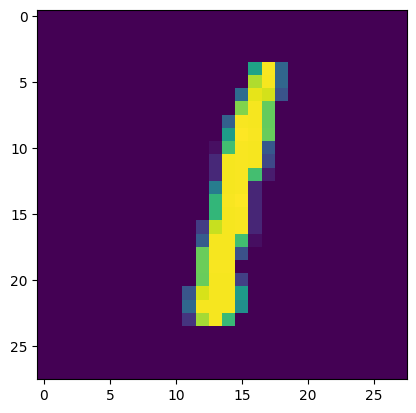

In [39]:
"""
Description : getting prediction from function imported from .pyc file
"""
print(base_model.predict(X_val[:1]))
plt.imshow(X_val[0])

In [40]:
"""
Description: Zip model
"""
model_encryption=0 #  0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
if model_encryption:
    make_archive(base_name=os.path.join(zip_path,"model"),root_dir=pyc_model_path,zip_format='zip')
else:
    make_archive(base_name=os.path.join(zip_path,"model"),root_dir=model_path,zip_format='zip')

# 5.0 AIShield API Call

In [41]:
"""
Description: AIShield API URL and subscription key
""" 
url="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
headers={'Cache-Control': 'no-cache',
                'Org-Id': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx',
                'x-api-key': "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
                }

### 5.1 Model Registration

In [42]:
"""
Description: call Model registration api to get unique model it and url to upload data, model and label
"""
model_registration_url = url + "/AIShieldModelRegistration/v1.5"
model_registration_payload = {
    'task_type':"IC",
    "analysis_type": "MEA"
}
new_request = requests.request(method="POST", url=model_registration_url, headers=headers, params=model_registration_payload)
new_request=json.loads(new_request.text)['Data']
model_id = new_request['ModelID']
data_upload_url = new_request['DataUploadURL']
label_upload_url = new_request['LabelUploadURL']
model_upload_url = new_request['ModelUploadURL']

print('model_id: ', model_id)

model_id:  a71f2a9b-13dc-4ac6-afe9-ae46ab3436f8


In [43]:
"""
Description: Files path
"""
data_path=os.path.join(zip_path,'data.zip')  # full path of data zip
label_path=os.path.join(zip_path,'label.zip') # full path of label zip
model_path=os.path.join(zip_path,'model.zip') # full path of model zip

In [44]:
def upload_file(url, file_path):
    """
    url: URL to upload
    file_path: file to be uploaded
    """
    new_request = requests.request(method="PUT", url=url, data=open(file_path,'rb'))
    status_cd = new_request.status_code
    if status_cd == 200:
        status = 'upload sucessful'
    else:
        status = 'upload failed'
    return status

In [45]:
"""
Description: Hit AIShield File Upload API
"""
data_upload_status = upload_file(data_upload_url, data_path)
label_upload_status = upload_file(label_upload_url, label_path)
model_upload_status = upload_file(model_upload_url, model_path)

print('data_upload_status: ', data_upload_status)
print('label_upload_status: ', label_upload_status)
print('model_upload_status: ', model_upload_status)

data_upload_status:  upload sucessful
label_upload_status:  upload sucessful
model_upload_status:  upload sucessful


### 5.2 Model Analysis

In [46]:
"""
Description: Payload for AIShield VulnerabilityReport api call
"""
payload={}
payload['model_id']=model_id
payload['input_dimensions']=str(input_shape)
payload['number_of_classes']=str(num_classes)
payload['attack_type']="blackbox"  
payload['number_of_attack_queries']=60000
payload['model_framework']='tensorflow'
payload['vulnerability_threshold']="0"
payload['normalize_data']="yes"
payload['defense_bestonly']="no"
payload['encryption_strategy']= model_encryption
payload['model_api_details']="no"
payload['use_model_api'] = "no"

In [69]:
"""
Description: Hit AIShield VulnerabilityReport api
"""
model_analysis_url = url + "/AIShieldModelAnalysis/v1.5"
if data_upload_status == "upload sucessful" and model_upload_status == "upload sucessful" and label_upload_status == "upload sucessful":
    new_request = requests.request(method="POST", url=model_analysis_url, params=payload,headers=headers)
    new_request=json.loads(new_request.text)
    for k, v in new_request.items():
        print("* {} : {}".format(k,v))
        

* ApiVersion : 1.5
* job_id : XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
* monitor_link : XXXXXXXXXXXXXXXXXXXx


In [70]:
"""
Description: Get job id from api response
"""
job_id=new_request['job_id']
print(f"Job id : {job_id}")

Job id : XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [49]:
def monitor_api_progress(new_job_id):
        job_status_url = url + "/AIShieldModelAnalysis/" + "JobStatusDetailed?JobID=" + new_job_id

        # status dictionary
        status_dictionary = {
            'ModelExploration_Status': 'na',
            'QueryGenerator_Status': 'na',
            'VunerabilityEngine_Status': 'na',
            'DefenseReport_Status': 'na',
        }
        counts = [0] * len(status_dictionary)
        failed_api_hit_count = 0
        while True:
            time.sleep(2)
            try:
                job_status_response = requests.request("GET", job_status_url, params={},
                                                       headers=headers)

                job_status_payload = json.loads(job_status_response.text)
                failing_key = 'ModelExploration_Status'
                for i, key in enumerate(status_dictionary.keys()):
                    if status_dictionary[key] == 'na':
                        if job_status_payload[key] == 'inprogress' and status_dictionary[key] == 'na':
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                        elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                            status_dictionary[key] = job_status_payload[key]
                            counts[i] += 1
                            print(str(key), ":", status_dictionary[key])

                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                    elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                        status_dictionary[key] = job_status_payload[key]
                        if counts[i] < 1:
                            print(str(key), ":", status_dictionary[key])
                        counts[i] += 1

                    else:
                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                if job_status_payload[failing_key] == 'failed':
                    break

                if status_dictionary['VunerabilityEngine_Status'] == 'passed' or status_dictionary[
                    'VunerabilityEngine_Status'] == 'completed' and job_status_payload[
                    'CurrentStatus'] == "Defense generation is not triggered":
                    print("\n Vulnerability score {} failed to cross vulnerability threshoold of {}".format(
                        job_status_payload['VulnerabiltyScore'], payload['vulnerability_threshold']))
                    break
                if job_status_payload['DefenseReport_Status'] == 'completed':
                    break
            except Exception as e:
                failed_api_hit_count += 1
                print("Error {}. trying {} ...".format(str(e), failed_api_hit_count))
                if failed_api_hit_count >= 3:
                    break
        return status_dictionary

In [50]:
"""
Description: Continuos monitoring of jod progress
"""
status_dictionary = monitor_api_progress(new_job_id=job_id)

ModelExploration_Status : inprogress
ModelExploration_Status : completed
QueryGenerator_Status : inprogress
QueryGenerator_Status : completed
VunerabilityEngine_Status : inprogress
VunerabilityEngine_Status : completed
DefenseReport_Status : inprogress
DefenseReport_Status : completed


In [51]:
def download_artifact(job_id, report_type='Vulnerability', file_format=0):
    """
    job_id: job_id  received after successful api call
    report_type: report to be downloaded
    file_format: change file_format to : 0- all report in zip
                        1- report in .txt
                        2- report in .pdf
                        3- report in .json
                        4- report in .xml
    """
    print("received report_type : {} and file format is: {}".format(report_type, file_format))
    report_url = url + "/AIShieldModelAnalysis/" + "GetReport?JobID=" + str(
        job_id) + "&ReportType=" + report_type + "&FileFormat=" + str(file_format)

    headers1 = headers
    headers1["content-type"] = "application/zip"

    response = requests.request("GET", report_url, params={}, headers=headers1)

    if file_format == 0 or file_format == "Attack_samples":
        with open(os.path.join(report_path, report_type + ".zip"), 'wb') as f:
            f.write(response.content)
    elif file_format == 1:
        with open(os.path.join(report_path, report_type + ".txt"), 'wb') as f:
            f.write(response.content)
    elif file_format == 2:
        with open(os.path.join(report_path, report_type + ".pdf"), 'wb') as f:
            f.write(response.content)
    elif file_format == 3:
        with open(os.path.join(report_path, report_type + ".json"), 'wb') as f:
            f.write(response.content)
    elif file_format == 4:
        with open(os.path.join(report_path, report_type + ".xml"), 'wb') as f:
            f.write(response.content)

In [52]:
"""
Description: download generated artifact
"""
if status_dictionary["VunerabilityEngine_Status"] == 'completed':
    download_artifact(job_id=job_id, report_type='Vulnerability', file_format=1) 
    download_artifact(job_id=job_id, report_type='Attack_samples', file_format=0)

if status_dictionary["DefenseReport_Status"] == 'completed':
    download_artifact(job_id=job_id, report_type='Defense', file_format=1)
    download_artifact(job_id=job_id, report_type='Defense_artifact', file_format=0)

received report_type : Vulnerability and file format is: 1
received report_type : Attack_samples and file format is: 0
received report_type : Defense and file format is: 1
received report_type : Defense_artifact and file format is: 0


In [53]:
"""
Description: log Vulnerability and defense report as an artifact
"""
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(os.path.join(report_path, "Vulnerability.txt"),  artifact_path="Vulnerability report")
    mlflow.log_artifact(os.path.join(report_path, "Defense.txt"),  artifact_path="Defense report")
    

In [54]:
def zip_extractor(file, extract_path=None, delete_zip=False):
    """
    extract zip file to the given path

    Parameters
    ----------
    file : path of zip file
    extract_path : path to extract zip file, default considered parent directory
    delete_zip: True, delete zip file after unzipping it

    Returns
    -------
    None.
    """
    if extract_path is None:
        extract_path = os.path.dirname(file)
    print("Extracting : {}".format(file))
    zf = zipfile.ZipFile(file=file, mode='r')
    zf.extractall(extract_path)
    zf.close()
    if delete_zip:
        os.remove(file)
        print("{} removed successfully.".format(file))


In [72]:
"""
Description: extract attack sample
"""
zip_extractor(file=os.path.join(report_path, 'Attack_samples.zip'), extract_path=sample_data)

'\nDescription: extract attack sample\n'

In [56]:
def load_data(path):
    """
    path: load data from given path
    """
    files_path = get_file_path(path)
    x = []
    for file in files_path:
        img = cv2.imread(file, 0)
        x.append(img)
    x = np.expand_dims(np.array(x), axis=-1)
    return x

In [57]:
"""
Description: load attack data
"""
x_attack = load_data(path=sample_data)

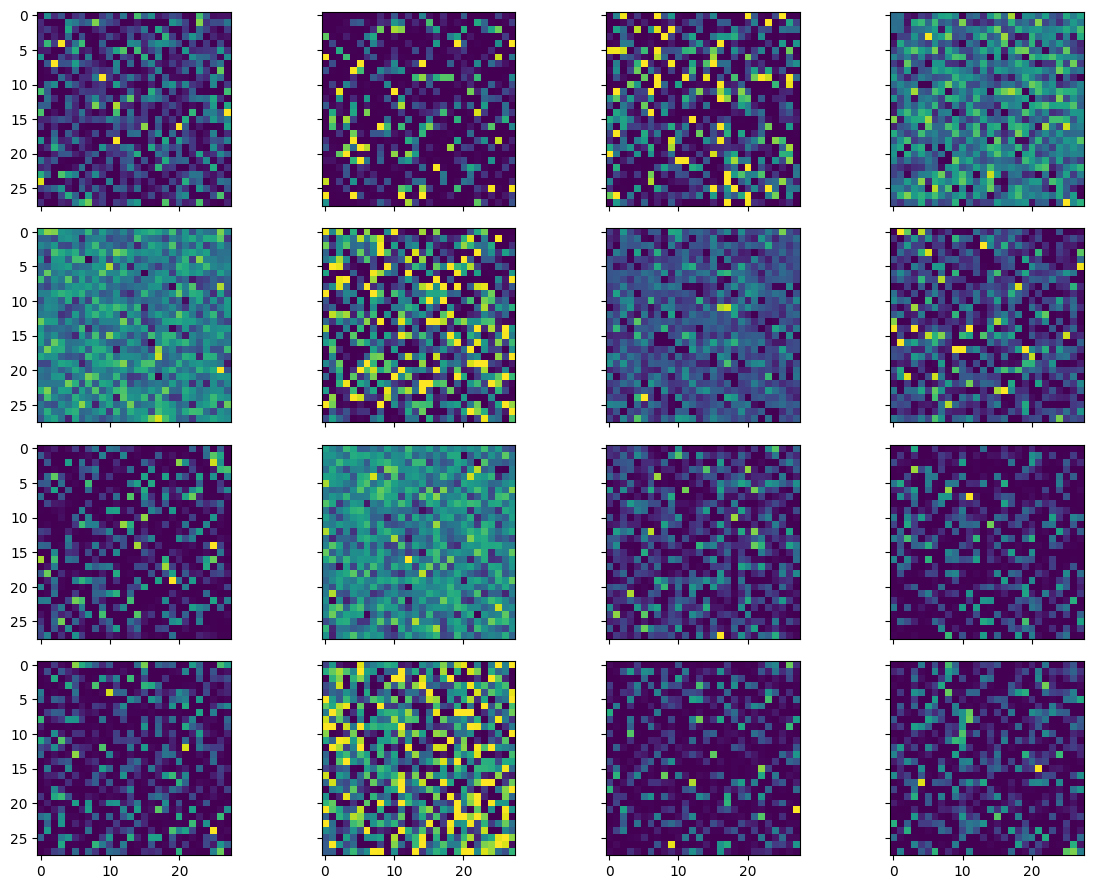

In [58]:
 plot(x=x_attack, row=4)

In [59]:
"""
Description: log attack data sample as an artifact
"""
with mlflow.start_run(run_id=run_id):
    files_path = get_file_path(path = sample_data)
    for file in files_path:
        mlflow.log_artifact(file,  artifact_path="sample data")    

In [71]:
"""
Description: Extracting defense artifact
"""
zip_extractor(file=os.path.join(report_path, 'Defense_artifact.zip'), extract_path=defense_artifact)

'\nDescription: Extracting defense artifact\n'

In [61]:
"""
Description: log defense artifact
"""
with mlflow.start_run(run_id=run_id):
    files_path = get_file_path(path = defense_artifact)
    for file in files_path:
        mlflow.log_artifact(file,  artifact_path="defense artifact") 

In [62]:
"""
Description: Load defense model
"""
defense_model_path = os.path.join(defense_artifact,'defense_model.h5')
defense_model = tf.keras.models.load_model(defense_model_path)

In [63]:
"""
Description: Use defense model
"""
from reports.defense_artifact import predict
defense = predict.AISDefenseModel(defense_model)

In [64]:
"""
Description: original data to get prediction
"""
label, prob = defense.predict(X_val[:5])
print("original data:\nlabel: {} \nprob: {}".format(label, prob))

1/1 [==============================] - 0s 306ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

original data:
label: ['not-attack' 'not-attack' 'not-attack' 'not-attack' 'not-attack'] 
prob: [1.         0.99999964 0.9999999  0.999974   0.9999999 ]


In [65]:
"""
Description: attack data to get prediction
"""
label, prob = defense.predict(x_attack[:5])
print("attack data:\nlabel: {} \nprob: {}".format(label, prob))

1/1 [==============================] - 0s 78ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

attack data:
label: ['attack' 'attack' 'attack' 'attack' 'attack'] 
prob: [1. 1. 1. 1. 1.]
